# Gridded Stitching

Note this will not work if connected to vpn and for some reasonn this jupyter notebook does not run in pycharm. 

What we are doing here is taking the stitched recepie from Abigail using it to stich together gridded data diretly from pangeo. 

In [123]:
# load libraries 
import xarray as xr
import fsspec as fsspec
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import intake 

## Define the functions we will use to process data.

The helper functions that can be used to load the data, select, and stitch the data. 

In [2]:
def load_data(path):
    """Extract data for a single file.

        :param path:                str of the location of the cmip6 data file on pangeo.
        :return:                    an xarray containing cmip6 data downloaded from the pangeo.
    """
    ds = xr.open_zarr(fsspec.get_mapper(path))
    return ds

def get_netcdf_values(i, dl, rp, fl):

    """Extract the archive values from the list of downloaded cmip data

        :param i:              int index of the row of the recipe data frame
        :param dl:             list of xarray cmip files
        :param rp:             data frame of the recipe
        :param fl:             list of the cmip files
        :return:               a slice of xarray (not sure confident on the technical term)
    """
    file = rp["file"][i]
    start_yr = str(rp["archive_start_yr"][i])
    end_yr = str(rp["archive_end_yr"][i])

    # Figure out which index level we are on and then get the
    # xarray from the list.
    index = int(np.where(fl == file)[0])
    extracted = dl[index]
    dat = extracted.sel(time=slice(start_yr, end_yr)).tas.values.copy()

    # TODO figure out why the date range is so does not include
    expected_len = len(pd.date_range(start=start_yr+"-01-01", end=end_yr+"-12-31", freq='M'))
    assert (len(dat) == expected_len), "Not enough data in " + file + "for period " + start_yr + "-" + end_yr

    return dat


def get_data_from_pangeo(fl):
    """Download all of the data from a pangeo file list

        :param fl:             list of the files to get data from
        :return:               list of xarray
    """
    data_list = []

    # this for loop is really really freaking slow need to figure out how
    # the heck to do this also only want to have to run it once runing it mulitple
    # times is awuful!
    for f in fl:
        o = load_data(f)
        data_list.append(o)

    return data_list


def stitch_gridded(rp, dl, fl):
    """stitch the gridded data together.

        :param rp:             data frame of the recepies
        :param dl:             list of the data files
        :param fl:             list of the data file names
        :return:               xarray data set

        TODO add a check to make sure that there is only one stitching id being passed into
        the function.
    """

    rp.reset_index(drop=True, inplace=True)
    out = get_netcdf_values(i=0, dl=dl, rp=rp, fl=fl)

    for i in range(1,len(rp)):
        new_vals = get_netcdf_values(i=i, dl=dl, rp=rp, fl=fl)
        out = np.concatenate((out, new_vals), axis=0)

    # Create a time series with the target data information
    # TODO this needs to be some sort of check that allows you to make sure that there is only 1 recipe being stitched
    # select monthly, daily, or annual data.
    start = str(min(rp["target_start_yr"]))
    end = str(max(rp["target_end_yr"]))

    # Note that the pd.date_range call need the date/month defined otherwise it will
    # truncate the year from start of first year to start of end year which is not
    # what we want. We want the full final year to be included in the times series.
    times = pd.date_range(start=start+"-01-01", end=end+"-12-31", freq='M')
    assert (len(out) == len(times)), "Problem with the length of time"

    # Extract the lat and lon information that will be used to structure the
    # empty netcdf file.
    lat = dl[0].lat.values
    lon = dl[0].lon.values

    # Creat the xarray data set
    rslt=xr.Dataset({'tas': xr.DataArray(
        out,
        coords=[times, lat, lon],
        dims=["time", "lat", 'lon'],
        # TODO what other meta data should be added? A path to the recepie file?
        attrs={'units': 'K',
               'stitching_id': str(rp['stitching_id'].unique())})
    })

    return rslt

## Import the data

In [3]:
# Read in the recepies!
recepie = pd.read_csv('/Users/dorh012/projects/2021/stitches/notebooks/stitches_dev/recpies_for_python.csv')

# Save a copy of the unique file list to minimize the number of files we have to
# download from pangeo.
file_list = recepie.file.unique().copy()

## Download all of the files!

In [169]:
# test out to make sure that the files can be downloaded from pangeo 
#load_data(file_list[0])

In [5]:
# Download all of the files we need for the different recepies. This
# may take a bit of time to run and WILL NOT WORK IF CONNECTED TO VPN.
# TODO add some sort of progress bar it is really hard to tell if it is running and it can a couple of mins.
data_list = get_data_from_pangeo(file_list)

## Generate the stitched gridded produts! 

In [6]:
rslts = []
for id in recepie['stitching_id'].unique():
    x = recepie[recepie['stitching_id'] == id].copy()
    out = stitch_gridded(rp=x, dl=data_list, fl=file_list)
    out.to_netcdf("stitched_"+id+".nc")
    rslts.append(out)

## Make the comparison netdf file!

It should be the historical+ssp245 r1i1p1f1 CanESM5 

In [10]:
path = 'gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical/r1i1p1f1/Amon/tas/gn/v20190429/'
hist = load_data(path)

In [16]:
path = 'gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp245/r1i1p1f1/Amon/tas/gn/v20190429/'
fut = load_data(path)

In [27]:
comparison = np.concatenate((hist.tas.values, fut.tas.values), axis=0)
times = pd.date_range(start="1850"+"-01-01", end="2100"+"-12-31", freq='M')

In [29]:
lat = hist.lat.values
lon = hist.lon.values
# Creat the xarray data set
rslt=xr.Dataset({'tas': xr.DataArray(
        comparison,
        coords=[times, lat, lon],
        dims=["time", "lat", 'lon'],
        # TODO what other meta data should be added? A path to the recepie file?
        attrs={'units': 'K',
               'stitching_id': 'actual data'})
    })

In [30]:
rslt.to_netcdf("stitched_real-data.nc")

## Compare Global Means 

In [168]:
# We will need the cell area data for the model. 
pangeo = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

query = dict(
experiment_id = ['historical', 'ssp585', 'ssp434'],
variable_id = 'tas',
member_id = ['r1i1p1f1'],
source_id = 'CanESM5',
table_id = 'Amon')

# Subbset the pangeo catalog with our query.
pangeo_subset = pangeo.search(require_all_on=["source_id"], **query)

# Make the subset of the pangeo catalog look nice.
pangeo_subset.df.groupby("source_id")[["experiment_id", "variable_id","table_id"]].nunique()
df_area = pangeo.df.query("variable_id == 'areacella' & source_id == 'CanESM5'")
ds_area = xr.open_zarr(fsspec.get_mapper(df_area.zstore.values[0]), consolidated=True)

In [158]:
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])
ta_timeseries = (ds.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area

In [157]:
def get_global_mean(ds_area, ds):
    total_area = ds_area.areacella.sum(dim=['lon', 'lat'])
    ta_timeseries = (ds.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
    vals = ta_timeseries.rolling(time=12).mean()
    return vals

In [165]:
canesm = get_global_mean(ds_area, rslt)
d1 = get_global_mean(ds_area, rslts[0])
d2 = get_global_mean(ds_area, rslts[1])
d3 = get_global_mean(ds_area, rslts[2])
d4 = get_global_mean(ds_area, rslts[3])
d5 = get_global_mean(ds_area, rslts[4])

### The CanESM data we used in the training 

Note that this 12 month rolling average of the monthly data. 

Text(0.5, 1.0, 'Global Mean Surface Air Temperature')

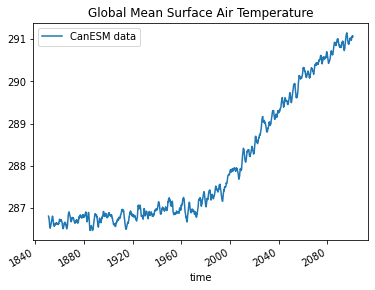

In [171]:
canesm.plot(label= "CanESM data")
plt.legend()
plt.title('Global Mean Surface Air Temperature')

### Compare the ensemble results with the CanESM results

Text(0.5, 1.0, 'Global Mean Surface Air Temperature')

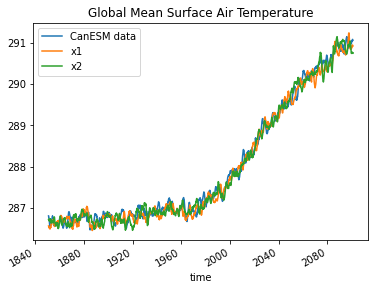

In [173]:
canesm.plot(label= "CanESM data")
d1.plot(label = "x1")
d2.plot(label = "x2")
#d3.plot(label = "x3")
#d4.plot(label = "x4")
#d5.plot(label = "x5")
plt.legend()
plt.title('Global Mean Surface Air Temperature')